In [223]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import optuna
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import shap


from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#### Functions

In [224]:
precision_scorer = make_scorer(precision_score, average="binary", zero_division=0)

In [225]:
def plot_precision_boxplot(results):
    model_names = []
    precision_scores_list = []

    # Extract model names and their respective precision scores
    for model_name, metrics in results.items():
        model_names.append(model_name)
        precision_scores_list.append(metrics["Precision"])

    # Create the boxplot
    fig, ax = plt.subplots()
    ax.boxplot(precision_scores_list, labels=model_names, vert=True, patch_artist=True)

    ax.set_xlabel("Models")
    ax.set_ylabel("Precision Scores")
    ax.set_title("Model Comparison - Precision (Boxplot)")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [226]:
pd.set_option("display.max_columns", None)

### Importing data

In [227]:
print(os.getcwd())

/Users/matheus/Projects/steam_analysis/steam-analysis


In [228]:
# os.chdir("../../")

In [229]:
data = pd.read_csv("data/interim/steam-transformed-data.csv")

#### Testing multiple classifier models

In [230]:
# Our data's beahaviour is not regular through time. For that reason We will be limiting ourselves to 2023.
data = data[data["year"] >= 2020]

In [231]:
data = data[data["Genres"].str.contains("Indie").fillna(False)].sort_values(
    by="total_reviews", ascending=False
)
data = data[data["Metacritic score"] == 0]
# data = data[data['total_reviews']>10]

In [232]:
# Adding a random noise column in order to better understand feature importances
data["random_noise"] = np.random.randn(len(data))

In [233]:
X = data[
    [
        "Achievements",
        "about_length",
        "n_screens",
        "n_movies",
        "n_tags",
        "n_languages",
        "has_publisher",
        "perceived_quality",
        "has_support_email",
        "has_support_url",
        "has_website",
        "random_noise",
    ]
]
y = data["success_500_threshold"]

In [234]:
# Check for colinearities(pearson)
X.corrwith(y).sort_values(ascending=False)

perceived_quality    0.213687
n_tags               0.163291
n_movies             0.152002
about_length         0.129064
n_screens            0.114814
has_website          0.093675
has_publisher        0.084485
Achievements         0.073866
has_support_url      0.067508
n_languages          0.043693
random_noise        -0.000856
has_support_email   -0.022880
dtype: float64

In [235]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [236]:
# List of classifier algos to be tested
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "LightGBM": LGBMClassifier(),
}


# Function to evaluate classifiers
def evaluate_classifier(clf, X, y, cv_splits=5):
    # Scoring for precision
    scoring = make_scorer(precision_score, average="binary", zero_division=0)

    # Calculate cross-validated scores for precision. Stratified folds by default.
    precision_scores = cross_val_score(clf, X, y, cv=cv_splits, scoring=scoring)
    mean_precision = np.mean(precision_scores)

    return precision_scores

In [237]:
results = {}
for clf_name, clf in classifiers.items():
    precision = evaluate_classifier(clf, X_train, y_train)
    results[clf_name] = {
        "Precision": precision,
    }

[LightGBM] [Info] Number of positive: 765, number of negative: 20136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 20901, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036601 -> initscore=-3.270389
[LightGBM] [Info] Start training from score -3.270389
[LightGBM] [Info] Number of positive: 765, number of negative: 20136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 20901, number of used features: 12
[LightGBM] [Info] [bin

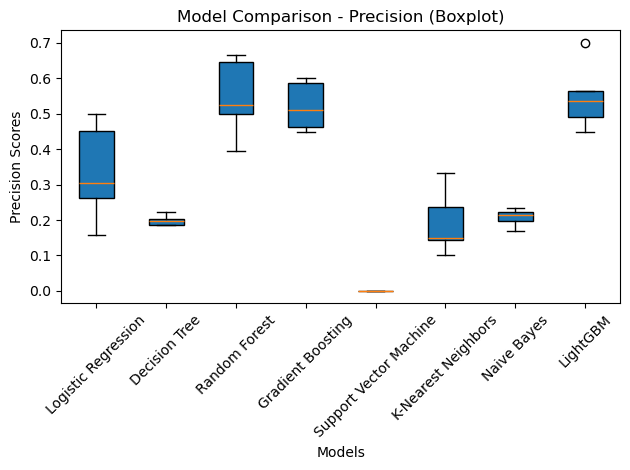

In [238]:
plot_precision_boxplot(results)

The analysis above show us that random forests may be a promising algorithm to model our data. We will train a new random forest model and optimize it with hyperparameter tuning.

In [239]:
# Base model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print(precision_score(y_test, rf.predict(X_test)))

0.4642857142857143


Next, we will tune our hyperparameters using optuna.

In [240]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample", None]
        ),
    }

    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(
        model, X_train, y_train, n_jobs=4, cv=5, scoring=precision_scorer
    )
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2024-05-24 18:27:56,229] A new study created in memory with name: no-name-4a0ff6cc-0768-4149-bf28-3a96e79c9a28
[I 2024-05-24 18:27:58,910] Trial 0 finished with value: 0.8142857142857143 and parameters: {'n_estimators': 98, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 15, 'class_weight': None}. Best is trial 0 with value: 0.8142857142857143.
[I 2024-05-24 18:27:59,709] Trial 1 finished with value: 0.2814049194110121 and parameters: {'n_estimators': 23, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8142857142857143.
[I 2024-05-24 18:28:01,185] Trial 2 finished with value: 0.20725929622336542 and parameters: {'n_estimators': 51, 'max_depth': 32, 'min_samples_split': 19, 'min_samples_leaf': 16, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8142857142857143.
[I 2024-05-24 18:28:01,958] Trial 3 finished with value: 0.28896464235734454 and parameters: {'n_estimators': 23, 'max_depth':

In [241]:
study.best_params

{'n_estimators': 43,
 'max_depth': 24,
 'min_samples_split': 17,
 'min_samples_leaf': 15,
 'class_weight': None}

In [243]:
y_test.sum()

214

In [244]:
rf = RandomForestClassifier(**study.best_params, random_state=42)
rf.fit(X_train, y_train)
score = precision_score(y_test, rf.predict(X_test))
print(score)

1.0


#### Interpreting the model
 
Permutation importance let us understand how each feature contributes to our model's generalization power. 

Shap values will tell us how the selected features are being used for every individual prediction our trained model does.

In [245]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary of SHAP values for the test set
shap.summary_plot(shap_values[1], X_test)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

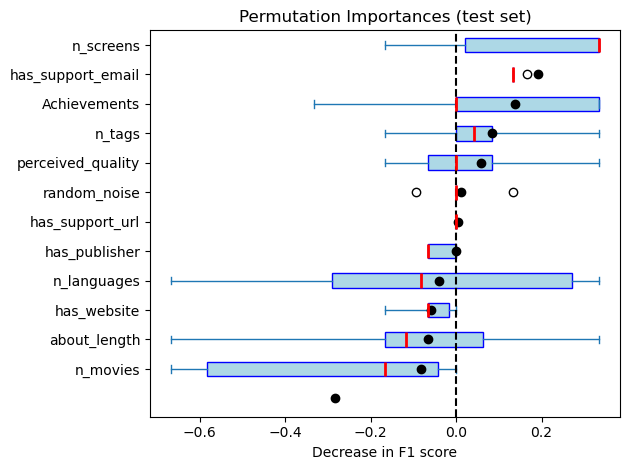

In [ ]:
result = permutation_importance(
    rf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=2,
    scoring=precision_scorer,
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# Plot permutation importances
fig, ax = plt.subplots()
importances.plot.box(
    vert=False,
    whis=10,
    ax=ax,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"),
    medianprops=dict(color="red", linewidth=2),
    meanprops=dict(marker="o", markerfacecolor="black", markeredgecolor="black"),
)

# Adding a mean line
for i in range(importances.shape[1]):
    mean_value = importances.iloc[:, i].mean()
    ax.plot(mean_value, i, "o", color="black")

ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in F1 score")
ax.figure.tight_layout()

plt.show()

#### Usable model
Let us train a model that can be used without prescient data. 

In [ ]:
data = data[data["year"] >= 2023]

In [ ]:
X_final_model = data[
    [
        "Achievements",
        "about_length",
        "n_screens",
        "n_movies",
        "n_tags",
        "n_languages",
        "has_publisher",
        "has_support_email",
        "has_support_url",
        "has_website",
    ]
]
y_final_model = data["success_500_threshold"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final_model, y_final_model, test_size=0.2, random_state=42
)

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample", None]
        ),
    }

    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(
        model, X_train, y_train, n_jobs=4, cv=5, scoring=precision_scorer
    )
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400)

[I 2024-05-23 16:23:45,916] A new study created in memory with name: no-name-45aa6429-c5b3-47c8-8b7d-954f9ec56443


[I 2024-05-23 16:23:46,238] Trial 0 finished with value: 0.22027197653019187 and parameters: {'n_estimators': 22, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 12, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.22027197653019187.
[I 2024-05-23 16:23:46,870] Trial 1 finished with value: 0.24774847917412485 and parameters: {'n_estimators': 67, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.24774847917412485.
[I 2024-05-23 16:23:47,623] Trial 2 finished with value: 0.23009044980443286 and parameters: {'n_estimators': 76, 'max_depth': 31, 'min_samples_split': 11, 'min_samples_leaf': 13, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.24774847917412485.
[I 2024-05-23 16:23:48,371] Trial 3 finished with value: 0.2563035893228382 and parameters: {'n_estimators': 81, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 3 with

In [13]:
rf = RandomForestClassifier(**study.best_params, random_state=42)
rf.fit(X_train, y_train)
score = precision_score(y_test, rf.predict_proba(X_test))
print(score)

0.8


In [14]:
rf.predict_proba(X_test)

array([[1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 0.00000000e+00],
       [9.26129537e-01, 7.38704634e-02],
       [9.99338624e-01, 6.61375661e-04]])

In [16]:
X_train.columns

Index(['Achievements', 'about_length', 'n_screens', 'n_movies', 'n_tags',
       'n_languages', 'has_publisher', 'has_support_email', 'has_support_url',
       'has_website'],
      dtype='object')